### This notebook downloads NEXRAD files from Amazon S3 and creates time-height plots of reflectivity over the ARM SGP Central Facility. 
Files are selected by date, NEXRAD site, and start/end times. Vertical columns of reflectivity are then extracted over the SGP site using its latitude and longitude and plotted on time-height plots

In [11]:
import pyart
import numpy as np
import nexradaws
import tempfile
import xarray as xr
import warnings
import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
def main():
    
    # Request files by station ID, start date/time, and end date/time (UTC)
    radar_id = 'KVNX'
    start = datetime.datetime(2019, 8, 22, 6, 0) 
    end = datetime.datetime(2019, 8, 22, 12, 0)
    
    # Central lat/lon of ARM SGP site 
    site_latlon = [36.607322, -97.487643]
    
    radarfiles, count_scans = get_radar_from_aws(radar_id, start, end)
    
    ds, scan_times = get_ref_cols(radarfiles, site_latlon, count_scans)

    time_sweep_plots(ds)
    
    time_height_plot_v1(ds, scan_times)
    
    time_height_plot_v2(ds, scan_times)

In [3]:
def get_radar_from_aws(radar_id, start, end):
    
    # Create temp file, connect to NEXRAD AWS, download tempfiles locally
    templocation = tempfile.mkdtemp()
    conn = nexradaws.NexradAwsInterface()

    scans = conn.get_avail_scans_in_range(start, end, radar_id)
    print("There are {} scans available between {} and {}\n".format(len(scans), start, end)) 
    
    # Get all the scans that don't end in MDM; count them
    count_scans = 0
    good_scans = []
    for i in range(len(scans)):
        this_str = str(scans[i])
        if this_str[-8::] != 'V06_MDM>':
            good_scans.append(scans[i])
            count_scans +=1
        else:
            i+=1
    
    # Download selected volume scans
    localfiles = conn.download(good_scans, templocation)
    
    return localfiles, count_scans

In [4]:
def get_ref_cols(radarfiles, site_latlon, count_scans):
    
    # Get vertical columns of reflectivity over the ARM SGP site
    
    # Create numpy arrays for sweeps, latitude and longitude of each gate,
    # height at each of the gates, and reflectivity (Z) at each of the gates
    sweep = np.arange(0, 18, 1)
    gate_lat_site = np.nan*np.ma.ones((count_scans,18))
    gate_lon_site = np.nan*np.ma.ones((count_scans,18))
    gate_hgt_site = np.nan*np.ma.ones((count_scans,18))
    Z_site = np.nan*np.ma.ones((count_scans,18))
    scan_times = []
    tol = 0.25
    j = 0 

    # Loop through the volume scans
    for scan in radarfiles.iter_success():
        print('Reading in: '+scan.filename)

        # Read in the volume scans, get the times of the scans
        radar = pyart.io.read(radarfiles.success[j].filepath)
        volume_scan_t = scan.scan_time
        scan_times.append(volume_scan_t)

        # Get rid of duplicate sweeps; only interested in the first sweep at a given height
        # Find the median elevation in each sweep to ID and select only the unique sweeps
        vcp = np.asarray([np.median(el_this_sweep) for el_this_sweep in radar.iter_elevation()], dtype=radar.elevation['data'].dtype)
        close_enough = (vcp/tol).astype('int32')
        unq_el, unq_idx = np.unique(close_enough, return_index=True)

        # Create a new radar object with only the unique sweeps
        myradar = radar.extract_sweeps(unq_idx)

        # Loop through all the sweeps in a volume scan
        for k in range(myradar.nsweeps):
            slice_start, slice_end = myradar.get_start_end(k)
            gate_longitude = myradar.gate_longitude['data'][slice_start:slice_end,:]
            gate_latitude = myradar.gate_latitude['data'][slice_start:slice_end,:]
            gate_altitude = myradar.gate_altitude['data'][slice_start:slice_end,:]

            # Find the gate closest to the desired site 
            # Get the lat,lon,alt,reflectivity of the gate closest to the desired site
            dist = np.sqrt(((gate_latitude - site_latlon[0])**2) + ((gate_longitude - site_latlon[1])**2))
            index = np.where(dist == np.min(dist))
            gate_lat_site[j,k] = gate_latitude[index[0][0], index[1][0]]
            gate_lon_site[j,k] = gate_longitude[index[0][0], index[1][0]]
            gate_hgt_site[j,k] = gate_altitude[index[0][0], index[1][0]]
            Z_site[j,k] = myradar.fields['reflectivity']['data'][slice_start+index[0][0], index[1][0]]

        if j < (count_scans-1):
            j += 1
            del radar
        else:
            print('Done')
            
            # Create an xarray dataset with dimensions time and sweep
            ds = xr.Dataset({'Z_site': (['time', 'sweep'], Z_site),
                        'gate_lat_site': (['time', 'sweep'], gate_lat_site),
                        'gate_lon_site': (['time', 'sweep'], gate_lon_site),
                        'gate_hgt_site': (['time', 'sweep'], gate_hgt_site)
                        },
                        coords={'time': scan_times,'sweep': sweep})
    return ds, scan_times

In [5]:
def time_sweep_plots(ds):
    
    # Quick plot of reflectivity (time vs. sweep)
    ds.Z_site.plot(x='time', y='sweep', vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
    plt.title('Reflectivity above ARM SGP Site')

In [6]:
def time_height_plot_v1(ds, scan_times):
    
    # Version 1 of the plots 
    # Y-axis (height) is calculated by averaging the gate heights of all gates at a given sweep
    
    # Average the gate heights for each of sweeps
    y = np.average(ds.gate_hgt_site, 0)
    x = scan_times
    xm, ym = np.meshgrid(x, y)

    # Make time-height plot of reflectivity over the site
    fig = plt.figure(figsize = [16,10])
    plt.pcolor(x, y, ds.Z_site.T,
                    vmin = -10, vmax = 64, cmap = pyart.graph.cm.NWSRef)

    plt.colorbar(label='NEXRAD Z (dBZ)')
    plt.xlabel('Time', size=15)
    plt.ylabel('Height (m)', size=15)

    times = ds.time.values
    datetm = []
    tm = []

    for x in scan_times:
        date_time = x.strftime('%m/%d/%y %H:%M:%S')
        t = x.strftime('%H:%M:%S')
        datetm.append(date_time)
        tm.append(t)
    plt.xticks(ticks=times, labels=tm, size=12)
    plt.yticks(size=12)
    plt.ylim(0,17500)
    ax = plt.gca()
    n=5
    ax.set_xticks(ax.get_xticks()[::n])
    fig.autofmt_xdate()

    plt.title('Reflectivity above ARM SGP Site: {}Z - {}Z\n'.format(datetm[0], datetm[-1]), size=20)


In [7]:
def time_height_plot_v2(ds, scan_times):
    
    # Version 2 of the plots
    # Evenly spaced height bins are created for the y-axis (height), 
    # reflectivity is then averaged between two closest bins prior to plotting
    
    # Create an array of size time by # height bins to hold scan times & avg ref
    x = ds.time
    y = np.arange(0.,16000.,800.)
    Z_ave = np.nan*np.ones((len(x), len(y)))
    xm, ym = np.meshgrid(y, x)

    # Calculate avg reflectivity between two height bins for time vs. height plots 
    for i in range(len(x)):
        for j in range(19):
            inds = np.argwhere(np.logical_and(ds.gate_hgt_site.values[i, :] >= y[j], 
                                              ds.gate_hgt_site.values[i, :] < y[j+1]))
            Z_ave[i, j] = np.nanmean(ds.Z_site.values[i, inds])
            
    # Make time-height plot of average reflectivity over the site
    fig = plt.figure(figsize = [16,10])
    plt.pcolormesh(ym, xm, Z_ave, vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
    plt.colorbar(label='NEXRAD Z (dBZ)')
    plt.xlabel('Time', size=15)
    plt.ylabel('Height (m)', size=15)

    datetm = []
    tm = []

    for x in scan_times:
        date_time = x.strftime('%m/%d/%y %H:%M:%S')
        t = x.strftime('%H:%M:%S')
        datetm.append(date_time)
        tm.append(t)
    plt.xticks(ticks=scan_times, labels=tm, size=12)
    plt.yticks(size=12)
    plt.ylim(0,17500)
    ax = plt.gca()
    n=5
    ax.set_xticks(ax.get_xticks()[::n])
    fig.autofmt_xdate()

    plt.title('Reflectivity above ARM SGP Site: {}Z - {}Z\n'.format(datetm[0], datetm[-1]), size=20)

There are 66 scans available between 2019-08-22 06:00:00 and 2019-08-22 12:00:00

Downloaded KVNX20190822_062023_V06
Downloaded KVNX20190822_062610_V06
Downloaded KVNX20190822_061431_V06
Downloaded KVNX20190822_060248_V06
Downloaded KVNX20190822_060839_V06
Downloaded KVNX20190822_063803_V06
Downloaded KVNX20190822_065603_V06
Downloaded KVNX20190822_064400_V06
Downloaded KVNX20190822_063203_V06
Downloaded KVNX20190822_070211_V06
Downloaded KVNX20190822_065001_V06
Downloaded KVNX20190822_070818_V06
Downloaded KVNX20190822_071426_V06
Downloaded KVNX20190822_072033_V06
Downloaded KVNX20190822_072640_V06
Downloaded KVNX20190822_073235_V06
Downloaded KVNX20190822_075046_V06
Downloaded KVNX20190822_075653_V06
Downloaded KVNX20190822_080301_V06
Downloaded KVNX20190822_074438_V06
Downloaded KVNX20190822_080909_V06
Downloaded KVNX20190822_073831_V06
Downloaded KVNX20190822_081500_V06
Downloaded KVNX20190822_083305_V06
Downloaded KVNX20190822_082102_V06
Downloaded KVNX20190822_084514_V06
Download

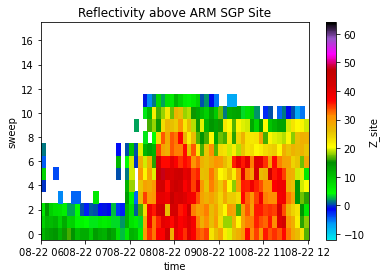

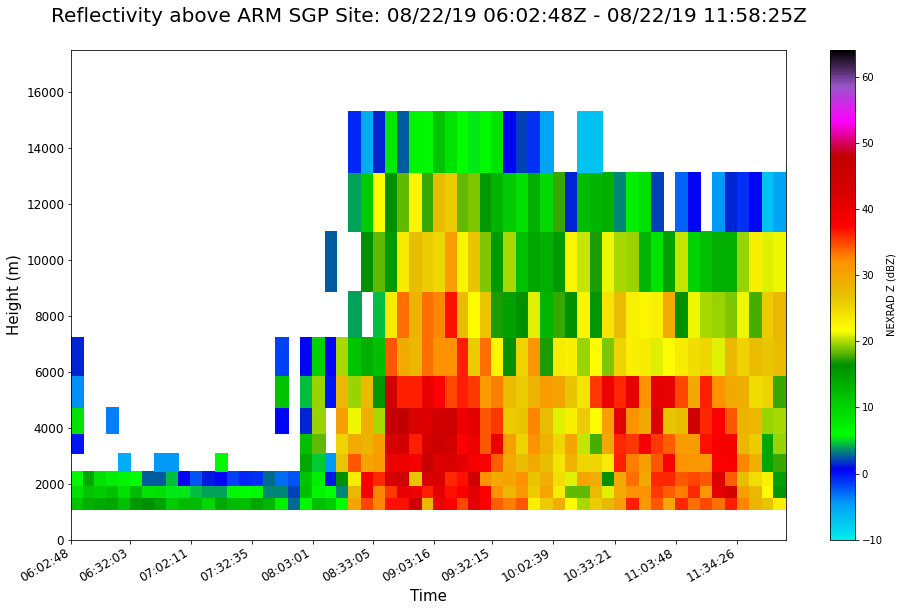

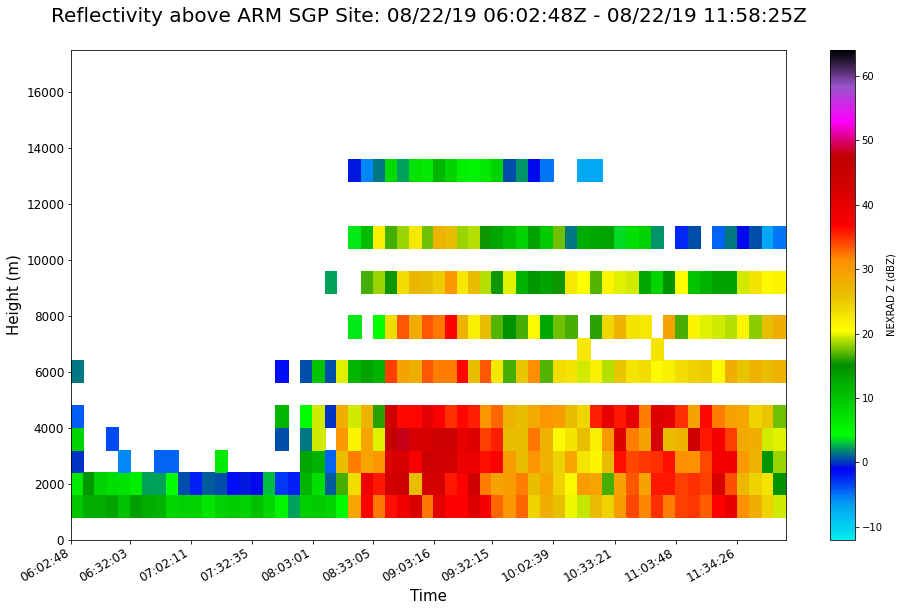

In [8]:
main()